In [1]:
#import libraries 
import matplotlib.pyplot as plt
import imageio
import math
import os
import cv2
import numpy as np
from skimage import io, color
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from google.colab.patches import cv2_imshow
from matplotlib.pyplot import figure

In [2]:
# initialization of parameters
A = 2500
wx = 2
wy = 7

In [3]:
def phi(x, y, A, wx, wy):
  return A*math.cos(2*math.pi*wx*x)*math.sin(2*math.pi*wy*y)

1) b.

In [4]:
def sampling(phi_rep, func, nx, ny, A, wx, wy):
  for i in range(ny):
    for j in range(nx):
      phi_rep[i][j]= func(j/(nx-1), i/(ny-1), A, wx, wy)
  return phi_rep

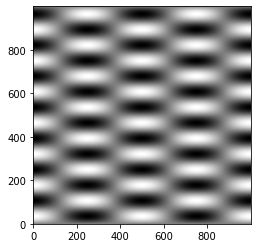

In [5]:
ny = 10**3
nx = 10**3
phi_digitized = np.zeros((ny,nx), dtype = np.float64)
_ = plt.imshow(sampling(phi_digitized, phi, nx, ny, A, wx, wy), cmap='gray', origin='lower')

1) c.

In [6]:
def phi_derivative_x(x, y, A, wx, wy):
  return -A*2*math.pi*wx*math.sin(2*math.pi*wx*x)*math.sin(2*math.pi*wy*y)

def phi_derivative_y(x, y, A, wx, wy):
  return A*2*math.pi*wy*math.cos(2*math.pi*wx*x)*math.cos(2*math.pi*wy*y)

def energy(func_digitized, nx, ny):
  return np.sum((func_digitized**2)/(nx*ny))

In [7]:
phi_x_deriv = np.zeros((ny,nx), dtype = np.float64)
phi_y_deriv = np.zeros((ny,nx), dtype = np.float64)

phi_derivative_x_digitized = sampling(phi_x_deriv, phi_derivative_x ,nx, ny, A, wx, wy)
phi_derivative_y_digitized = sampling(phi_y_deriv, phi_derivative_y, nx, ny, A, wx, wy)

x_energy = energy(phi_derivative_x_digitized, nx, ny)
y_energy = energy(phi_derivative_y_digitized, nx, ny)

value_range = phi_digitized.max() - phi_digitized.min()

print("my signal max= " + str(phi_digitized.max()))
print("my signal min= " + str(phi_digitized.min()))
print("value range = " + str(value_range))
print('horizontal derative energey = '+str(x_energy))
print('vertical derative energey = '+str(y_energy))

my signal max= 2499.9969095714937
my signal min= -2499.9969095714937
value range = 4999.993819142987
horizontal derative energey = 246246876.5472896
vertical derative energey = 3028614503.095629


1) e.


In [8]:
# implementing the numerical parameter calculation
def calculate_optimal_params(x_energy, y_energy, value_range, budget):
  b=math.log2((budget*(value_range**2)*math.log(2))/math.sqrt(x_energy*y_energy))/2
  nx=math.sqrt((budget/b)*math.sqrt(x_energy/y_energy))
  ny=nx*math.sqrt(y_energy/x_energy)
 
  if(round(b)*round(nx)*round(ny)<=budget):
    return round(nx), round(ny), round(b)
 
  return math.floor(nx),math.floor(ny),math.floor(b)

In [9]:
nx_low_opt, ny_low_opt, b_low_opt = calculate_optimal_params(x_energy, y_energy, value_range, 5000)
nx_high_opt, ny_high_opt, b_high_opt = calculate_optimal_params(x_energy, y_energy, value_range, 50000)

print('Optimal low budget  Nx =  '+str(nx_low_opt)+'  Ny = '+str(ny_low_opt)+'  b = '+str(b_low_opt))
print('Optimal high budget Nx =  '+str(nx_high_opt)+'  Ny = '+str(ny_high_opt)+'  b = '+str(b_high_opt))

Optimal low budget  Nx =  21  Ny = 73  b = 3
Optimal high budget Nx =  53  Ny = 188  b = 5


1) f.


In [10]:
# implementing the searching procedure 
def search_bit_allocation(x_energy, y_energy, value_range, budget):
  min_mse = np.float64(-1)
  optimal_coe = []
  # limiting the range of b in order to not get an overflow for the calculation of 2^(2b)
  for b in range(1,512):
    for nx in range(1,budget//b+1):
      ny = budget//(nx*b)
      mse = (1/(12*(nx**2)))*x_energy + (1/(12*(ny**2)))*y_energy + (1/12)*((value_range**2)/(2**(2*b)))
      if (mse < min_mse or min_mse == -1):
        min_mse = mse
        optimal_coe = [nx,ny,b]
  return optimal_coe

1) g.

In [11]:
#1.g applying the search procdure on B_high and B_low and comparing to the calculation result
nx_low, ny_low, b_low = search_bit_allocation(x_energy, y_energy, value_range, 5000)
nx_high, ny_high, b_high = search_bit_allocation(x_energy, y_energy, value_range, 50000)

phi_digitized_budget_low = np.zeros((ny_low,nx_low), dtype = np.float64)
phi_digitized_budget_high = np.zeros((ny_high, nx_high), dtype = np.float64)

# calculation result the optimal from section e
phi_digitized_budget_low_opt = np.zeros((ny_low_opt,nx_low_opt), dtype = np.float64)
phi_digitized_budget_high_opt = np.zeros((ny_high_opt, nx_high_opt), dtype = np.float64)

In [12]:
print('Optimal low budget:  Nx =  '+str(nx_low_opt)+',  Ny = '+str(ny_low_opt)+',  b = '+str(b_low_opt))
print('Optimal high budget: Nx =  '+str(nx_high_opt)+',  Ny = '+str(ny_high_opt)+',  b = '+str(b_high_opt))

print('\nSearch result low budget:  Nx =  '+str(nx_low)+',  Ny = '+str(ny_low)+',  b = '+str(b_low))
print('Search result high budget: Nx =  '+str(nx_high)+',  Ny = '+str(ny_high)+',  b = '+str(b_high))

Optimal low budget:  Nx =  21,  Ny = 73,  b = 3
Optimal high budget: Nx =  53,  Ny = 188,  b = 5

Search result low budget:  Nx =  21,  Ny = 79,  b = 3
Search result high budget: Nx =  54,  Ny = 185,  b = 5


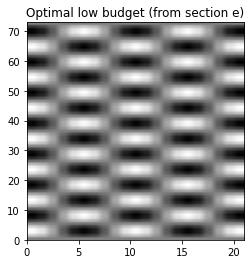

In [13]:
phi_digitized_budget_low_opt = sampling(phi_digitized_budget_low_opt, phi, nx_low_opt, ny_low_opt, A, wx, wy)
plt.title('Optimal low budget (from section e)')
_ = plt.imshow((phi_digitized_budget_low_opt+A)/2*A, cmap='gray', origin='lower', extent=[0,nx_low_opt,0,ny_low_opt], aspect=nx_low_opt/ny_low_opt)

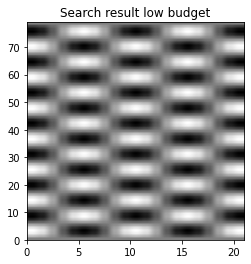

In [14]:
phi_digitized_budget_low = sampling(phi_digitized_budget_low, phi, nx_low, ny_low, A, wx, wy)
plt.title('Search result low budget')
_ = plt.imshow((phi_digitized_budget_low+A)/2*A, cmap='gray', origin='lower', extent=[0,nx_low,0,ny_low], aspect=nx_low/ny_low)

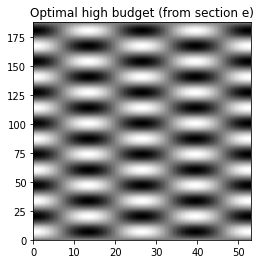

In [15]:
phi_digitized_budget_high_opt = sampling(phi_digitized_budget_high_opt, phi, nx_high_opt, ny_high_opt, A, wx, wy)
plt.title('Optimal high budget (from section e)')
_ = plt.imshow((phi_digitized_budget_high_opt+A)/2*A, cmap='gray', origin='lower',
               extent=[0,nx_high_opt,0,ny_high_opt], aspect=nx_high_opt/ny_high_opt)

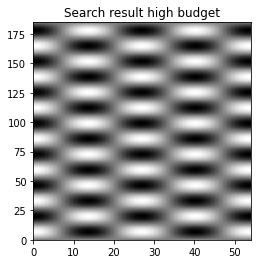

In [16]:
phi_digitized_budget_high = sampling(phi_digitized_budget_high, phi, nx_high, ny_high, A, wx, wy)
plt.title('Search result high budget')
_ = plt.imshow((phi_digitized_budget_high+A)/2*A, cmap='gray', origin='lower', extent=[0,nx_high,0,ny_high], aspect=nx_high/ny_high)

1) h.


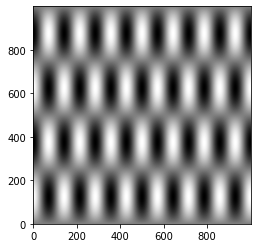

In [17]:
# 1.h - repeating the analysis for wx=7, wy=2
wx = 7
wy = 2

phi_digitized = np.zeros((ny,nx), dtype = np.float64)
_ = plt.imshow(sampling(phi_digitized, phi, nx, ny, A, wx, wy), cmap='gray', origin='lower')

In [18]:
phi_x_deriv = np.zeros((ny,nx), dtype = np.float64)
phi_y_deriv = np.zeros((ny,nx), dtype = np.float64)

phi_derivative_x_digitized = sampling(phi_x_deriv, phi_derivative_x ,nx, ny, A, wx, wy)
phi_derivative_y_digitized = sampling(phi_y_deriv, phi_derivative_y, nx, ny, A, wx, wy)

x_energy = energy(phi_derivative_x_digitized, nx, ny)
y_energy = energy(phi_derivative_y_digitized, nx, ny)

value_range = phi_digitized.max() - phi_digitized.min()

print("my signal max= " + str(phi_digitized.max()))
print("my signal min= " + str(phi_digitized.min()))
print("value range = " + str(value_range))
print('horizontal derative energey = '+str(x_energy))
print('vertical derative energey = '+str(y_energy))

my signal max= 2499.9969095714937
my signal min= -2499.9969095714937
value range = 4999.993819142987
horizontal derative energey = 3016524237.7042975
vertical derative energey = 247233836.98739842


In [19]:
nx_low_opt, ny_low_opt, b_low_opt = calculate_optimal_params(x_energy, y_energy, value_range, 5000)
nx_high_opt, ny_high_opt, b_high_opt = calculate_optimal_params(x_energy, y_energy, value_range, 50000)

print('Optimal low budget  Nx =  '+str(nx_low_opt)+'  Ny = '+str(ny_low_opt)+'  b = '+str(b_low_opt))
print('Optimal high budget Nx =  '+str(nx_high_opt)+'  Ny = '+str(ny_high_opt)+'  b = '+str(b_high_opt))

Optimal low budget  Nx =  72  Ny = 21  b = 3
Optimal high budget Nx =  187  Ny = 53  b = 4


In [20]:
# applying the search procdure on B_high and B_low and comparing to the calculation result
nx_low, ny_low, b_low = search_bit_allocation(x_energy, y_energy, value_range, 5000)
nx_high, ny_high, b_high = search_bit_allocation(x_energy, y_energy, value_range, 50000)

phi_digitized_budget_low = np.zeros((ny_low,nx_low), dtype = np.float64)
phi_digitized_budget_high = np.zeros((ny_high, nx_high), dtype = np.float64)

# calculation result the optimal from section e
phi_digitized_budget_low_opt = np.zeros((ny_low_opt,nx_low_opt), dtype = np.float64)
phi_digitized_budget_high_opt = np.zeros((ny_high_opt, nx_high_opt), dtype = np.float64)

In [21]:
print('Optimal low budget:  Nx =  '+str(nx_low_opt)+',  Ny = '+str(ny_low_opt)+',  b = '+str(b_low_opt))
print('Optimal high budget: Nx =  '+str(nx_high_opt)+',  Ny = '+str(ny_high_opt)+',  b = '+str(b_high_opt))

print('\nSearch result low budget:  Nx =  '+str(nx_low)+',  Ny = '+str(ny_low)+',  b = '+str(b_low))
print('Search result high budget: Nx =  '+str(nx_high)+',  Ny = '+str(ny_high)+',  b = '+str(b_high))

Optimal low budget:  Nx =  72,  Ny = 21,  b = 3
Optimal high budget: Nx =  187,  Ny = 53,  b = 4

Search result low budget:  Nx =  79,  Ny = 21,  b = 3
Search result high budget: Nx =  185,  Ny = 54,  b = 5


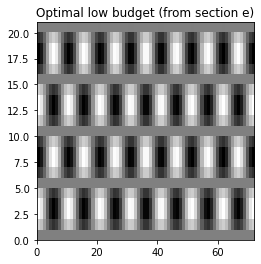

In [22]:
phi_digitized_budget_low_opt = sampling(phi_digitized_budget_low_opt, phi, nx_low_opt, ny_low_opt, A, wx, wy)
plt.title('Optimal low budget (from section e)')
_ = plt.imshow((phi_digitized_budget_low_opt+A)/2*A, cmap='gray', origin='lower', extent=[0,nx_low_opt,0,ny_low_opt], aspect=nx_low_opt/ny_low_opt)

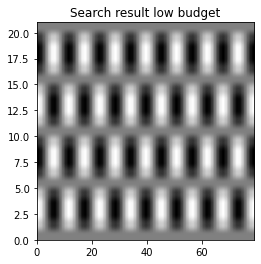

In [23]:
phi_digitized_budget_low = sampling(phi_digitized_budget_low, phi, nx_low, ny_low, A, wx, wy)
plt.title('Search result low budget')
_ = plt.imshow((phi_digitized_budget_low+A)/2*A, cmap='gray', origin='lower', extent=[0,nx_low,0,ny_low], aspect=nx_low/ny_low)

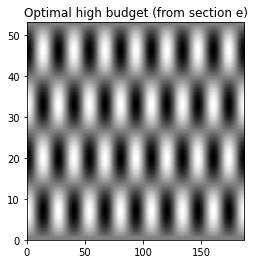

In [24]:

phi_digitized_budget_high_opt = sampling(phi_digitized_budget_high_opt, phi, nx_high_opt, ny_high_opt, A, wx, wy)
plt.title('Optimal high budget (from section e)')
_ = plt.imshow((phi_digitized_budget_high_opt+A)/2*A, cmap='gray', origin='lower', extent=[0,nx_high_opt,0,ny_high_opt], aspect=nx_high_opt/ny_high_opt)


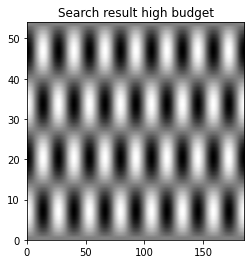

In [25]:
phi_digitized_budget_high = sampling(phi_digitized_budget_high, phi, nx_high, ny_high, A, wx, wy)
plt.title('Search result high budget')
_ = plt.imshow((phi_digitized_budget_high+A)/2*A, cmap='gray', origin='lower', extent=[0,nx_high,0,ny_high], aspect=nx_high/ny_high)